# RL w/ Verifiable Rewards Experiments
Default to left-to-right arithmetic with shared helpers in `rlvr_math.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import torch
from rlvr_math import (
    DEFAULT_MODEL_ID,
    TaskConfig,
    TrainConfig,
    measure_baseline_accuracy,
    train_grpo_integer_math,
    load_trainer_logs,
    load_mem_log,
    plot_losses,
    plot_memory,
    summarize_logs,
)

logging.basicConfig(level=logging.INFO, format="%(message)s")

USE_4BIT = False  # start simple
DTYPE = torch.float32  # for compat w/ GRPO framework :/

task_cfg = TaskConfig(
    task_mode="ltr",
    ltr_min_steps=3,
    ltr_max_steps=4,
    val_range=999,
    mul_range=20,
)

eval_seed = 123


### Baseline accuracy (matches training task)
Using left-to-right arithmetic to keep evaluation aligned with the RL task.

In [2]:
baseline = measure_baseline_accuracy(
    model_id=DEFAULT_MODEL_ID,
    task_cfg=task_cfg,
    n_eval=50,
    device="cuda",
    dtype=DTYPE,
    load_in_4bit=USE_4BIT,
    eval_seed=eval_seed,
)
baseline

`torch_dtype` is deprecated! Use `dtype` instead!
We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
{
  "model": "Qwen/Qwen3-0.6B",
  "task_mode": "ltr",
  "n": 50,
  "accuracy": 0.24,
  "samples": [
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?",
      "gold": 197,
      "raw": "-454 - (-779) + 718 - 846 = 718 - 846 = -128\n\n-128",
      "pred": -128,
      "ok": false
    },
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?",
      "gold": -2890,
      "raw": "-319 - (-302) * (-1

{'model': 'Qwen/Qwen3-0.6B',
 'task_mode': 'ltr',
 'n': 50,
 'accuracy': 0.24,
 'samples': [{'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?',
   'gold': 197,
   'raw': '-454 - (-779) + 718 - 846 = 718 - 846 = -128\n\n-128',
   'pred': -128,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?',
   'gold': -2890,
   'raw': '-319 - (-302) * (-17) * (-10) = -319 + 302 * 17 * 10 = -319 + 5134 = 5115\n\nThe result is 5115.',
   'pred': 5115,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n438 - -497 * -10 - -996\nWhat is the result?',
   'gold': -8354,
   'raw': '438 - -497 = 935  \n935 * -10 = -9350  \n-9350 - -996 = -9350 + 996 = -8354\n\nThe result is -8354.',
   'pred': -8354,
   'ok': True},
  {'prob

### GRPO training
Defaults target the LTR task with concise logging and quick-run sizing.

In [3]:
cfg = TrainConfig(
    model_id=DEFAULT_MODEL_ID,
    task=task_cfg,
    train_seed=42,
    eval_seed=eval_seed,
    quick_run=True,
    run_name="grpo-math-quick",
    output_dir="qwen3-06b-grpo-math-quick",
    logging_steps=5,
    load_in_4bit=USE_4BIT,
    dtype=DTYPE,
)

trainer = train_grpo_integer_math(cfg)

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!
We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
[mem] start used=4.73GiB free=27.12GiB total=31.84GiB reserved=2.91GiB
/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.021200,0.010577
100,0.013500,0.007081
150,0.006300,0.008134
200,0.010700,0.010417


[mem][step 5] used=9.96GiB (31%) step_t=14.33s tok/s~1143 seq/s~8.9 ETA~46m35s
[log][step 5] loss=-0.0105 reward=0.362 ema=0.159 adv~0.360 kl=0.0027
[mem][step 10] used=9.96GiB (31%) step_t=14.03s tok/s~1168 seq/s~9.1 ETA~44m24s
[log][step 10] loss=0.0169 reward=0.325 ema=0.220 adv~0.287 kl=0.0383
[mem][step 15] used=9.96GiB (31%) step_t=13.57s tok/s~1207 seq/s~9.4 ETA~41m51s
[log][step 15] loss=0.0108 reward=0.471 ema=0.450 adv~0.386 kl=0.0850
[mem][step 20] used=9.96GiB (31%) step_t=12.52s tok/s~1309 seq/s~10.2 ETA~37m33s
[log][step 20] loss=-0.0164 reward=0.438 ema=0.392 adv~0.299 kl=0.1390
[mem][step 25] used=9.96GiB (31%) step_t=11.57s tok/s~1416 seq/s~11.1 ETA~33m44s
[log][step 25] loss=0.0064 reward=0.470 ema=0.473 adv~0.371 kl=0.0987
[mem][step 30] used=9.96GiB (31%) step_t=11.52s tok/s~1422 seq/s~11.1 ETA~32m38s
[log][step 30] loss=-0.0066 reward=0.485 ema=0.512 adv~0.382 kl=0.1038
[mem][step 35] used=9.96GiB (31%) step_t=11.46s tok/s~1430 seq/s~11.2 ETA~31m30s
[log][step 35] 

### Training diagnostics

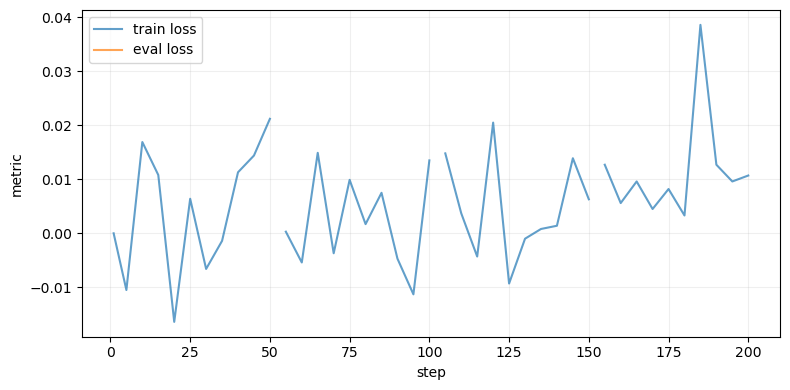

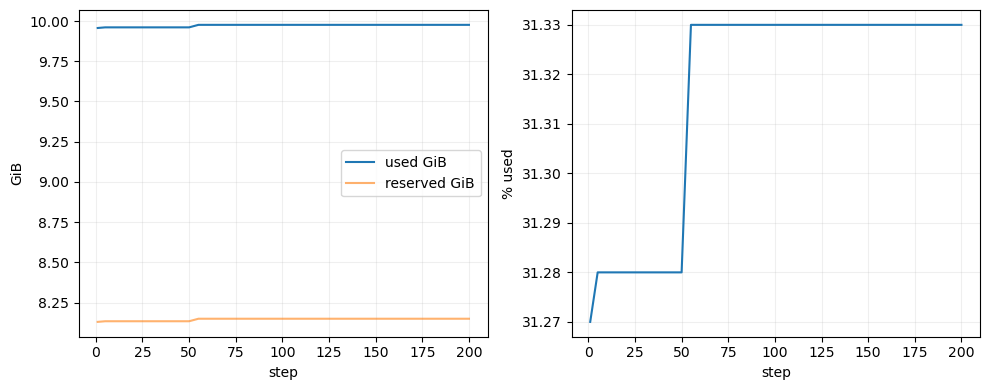

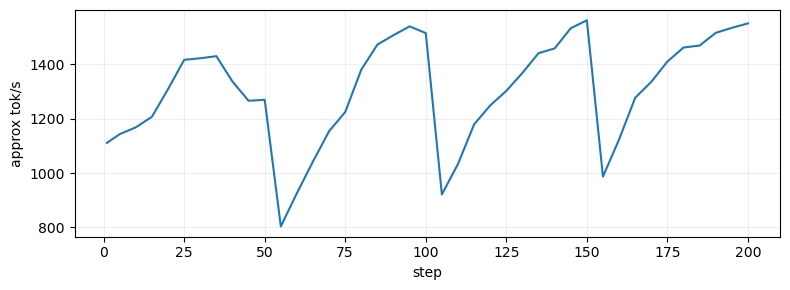

/home/jan/workspace/transformer-experiments/rlvr_math.py:877: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  out["final_train_loss"] = float(pd.to_numeric(df["loss"], errors="coerce").dropna().tail(1))
{
  "final_train_loss": 0.0107,
  "best_eval_loss": 0.007081150077283382,
  "peak_used_gib": 9.9761,
  "mean_tok_s": 1321.6736956521738
}


{'final_train_loss': 0.0107,
 'best_eval_loss': 0.007081150077283382,
 'peak_used_gib': 9.9761,
 'mean_tok_s': 1321.6736956521738}

In [6]:
df = load_trainer_logs(cfg.output_dir)
dfm = load_mem_log(cfg.output_dir)
plot_losses(df)
plot_memory(dfm)
summarize_logs(df, dfm)

In [5]:
from transformers import AutoTokenizer
from rlvr_math import evaluate_model_accuracy

tok_ft = AutoTokenizer.from_pretrained(cfg.model_id, trust_remote_code=True)
rlvr_eval = evaluate_model_accuracy(
    model=trainer.model,
    tok=tok_ft,
    task_cfg=task_cfg,
    n_eval=100,
    device=cfg.device,
    max_new_tokens=cfg.max_completion_tok,
    eval_seed=eval_seed,
)
rlvr_eval


{
  "model": "Qwen/Qwen3-0.6B",
  "task_mode": "ltr",
  "n": 100,
  "accuracy": 0.89,
  "samples": [
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?",
      "gold": 197,
      "raw": "-454 - (-779) = -454 + 779 = 325  \n325 + 718 = 1043  \n1043 - 846 = 197  \n\n197",
      "pred": 197,
      "ok": true
    },
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?",
      "gold": -2890,
      "raw": "-319 - (-302) = -319 + 302 = -17  \n-17 * -17 = 289  \n289 * -10 = -2890  \n\nThe result is -2890.",
      "pred": -2890,
      "ok": true
    },
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n438 - -497 * -10 - -996\nWhat is the result?",
      "gold": -8354,
      "raw": "438 - (-497) = 438 + 497 = 935  \n935

{'model': 'Qwen/Qwen3-0.6B',
 'task_mode': 'ltr',
 'n': 100,
 'accuracy': 0.89,
 'samples': [{'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-454 - -779 + 718 - 846\nWhat is the result?',
   'gold': 197,
   'raw': '-454 - (-779) = -454 + 779 = 325  \n325 + 718 = 1043  \n1043 - 846 = 197  \n\n197',
   'pred': 197,
   'ok': True},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-319 - -302 * -17 * -10\nWhat is the result?',
   'gold': -2890,
   'raw': '-319 - (-302) = -319 + 302 = -17  \n-17 * -17 = 289  \n289 * -10 = -2890  \n\nThe result is -2890.',
   'pred': -2890,
   'ok': True},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n438 - -497 * -10 - -996\nWhat is the result?',
   'gold': -8354,
   'raw': '438 - (-497) = 438 + 497 = 935  \n935 * -10 = -9350  \n-9350 - (-996) = -9350 + 996 = -9354\n\nThe result is -9354

__accuracy increases from 0.25 to 0.89! _not bad_.__